In [73]:
try:
    from qiskit.primitives import Estimator as RefEstimator
    # REMOVED V2 gradient import - rely on EstimatorQNN default or None
    from qiskit.circuit import QuantumCircuit, ParameterVector
    from qiskit.quantum_info import SparsePauliOp
    from qiskit_machine_learning.connectors import TorchConnector
    from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN
    # Log the qiskit-machine-learning version
    import qiskit_machine_learning
    logging.info(f"Using qiskit-machine-learning version: {qiskit_machine_learning.__version__}")

except ImportError as e:
    logging.error(f"Failed to import Qiskit V2 components: {e}. Ensure qiskit>=1.0 and qiskit-machine-learning are installed and compatible.")
    raise

2025-10-26 22:30:51,337 - INFO - Using qiskit-machine-learning version: 0.7.2


In [75]:
# Logging setup (prevents duplicate handlers on reruns)
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    force=True)
logger = logging.getLogger(__name__)
logger.info('Logging configured (force=True).')

2025-10-26 22:30:58,759 - INFO - Logging configured (force=True).


In [78]:
# ...existing code...
from pathlib import Path
DATA_PATH = Path("D:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\creditcard_data.csv")
assert DATA_PATH.exists(), f'Not found: {DATA_PATH}'
data = pd.read_csv(DATA_PATH)
# ...existing code...

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
class FraudDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.indices = torch.arange(len(features))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.indices[idx]

In [80]:
def get_fraud_dataloaders(data_path: str, batch_size: int, n_fraud_points: int = 200, n_non_fraud_points: int = 600, n_components: int = 10):
    DATA_PATH = Path("D:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\creditcard_data.csv")
    assert DATA_PATH.exists(), f'Not found: {DATA_PATH}'
    data = pd.read_csv(DATA_PATH)
    
    data_fraud = data.loc[data['Class'] == 1]
    data_non_fraud = data.loc[data['Class'] == 0]

    data_fraud_train = data_fraud.sample(n=n_fraud_points, random_state=42)
    data_fraud_test = data_fraud.drop(index=data_fraud_train.index)
    data_non_fraud_train = data_non_fraud.sample(n=n_non_fraud_points, random_state=42)
    data_non_fraud_test = data_non_fraud.drop(index=data_non_fraud_train.index)

    data_train = pd.concat([data_non_fraud_train, data_fraud_train])
    data_test = pd.concat([data_non_fraud_test, data_fraud_test])

    x_train = data_train.drop(['Time', 'Class'], axis=1).values
    y_train = data_train['Class'].values
    x_test = data_test.drop(['Time', 'Class'], axis=1).values
    y_test = data_test['Class'].values

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)
    
    print(f"Data processed. Train shape: {x_train_pca.shape}, Test shape: {x_test_pca.shape}")

    train_dataset = FraudDataset(features=x_train_pca, labels=y_train)
    test_dataset = FraudDataset(features=x_test_pca, labels=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader


In [82]:
# Prefer a robust Reference Estimator; Aer can fail depending on version/build
try:
    from qiskit.primitives import Estimator as RefEstimator
    CPU_ESTIMATOR = RefEstimator()  # pure-Python reference, safest cross-platform
    logging.getLogger(__name__).info("Using qiskit.primitives.Estimator (Reference).")
except Exception as e:
    # Fallback to AerEstimator without backend_options that can break on some builds
    from qiskit_aer.primitives import Estimator as AerEstimator
    try:
        CPU_ESTIMATOR = AerEstimator()
        logging.getLogger(__name__).warning(f"Falling back to AerEstimator: {e}")
    except Exception as ae:
        raise RuntimeError(f"Could not create any Estimator. Ref error: {e}; Aer error: {ae}")


C:\Users\PARAM\AppData\Local\Temp\ipykernel_14436\850519443.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  CPU_ESTIMATOR = RefEstimator()  # pure-Python reference, safest cross-platform
2025-10-26 22:31:20,181 - INFO - Using qiskit.primitives.Estimator (Reference).


In [85]:
# ...existing code...
class QuantumAutoencoder(nn.Module):
    def __init__(self, n_qubits: int, q_depth: int, n_layers: int, dim_lis: list):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth

        self.encoder = create_qiskit_qnn(n_qubits=self.n_qubits, q_depth=self.q_depth)

        # Build decoder purely from dim_lis (ignore n_layers to avoid index errors)
        hidden_dims = list(dim_lis or [])
        decoder_layers = []
        prev = self.n_qubits
        for h in hidden_dims:
            decoder_layers.append(nn.Linear(prev, h))
            decoder_layers.append(nn.ReLU())
            prev = h
        decoder_layers.append(nn.Linear(prev, self.n_qubits))
        self.decoder = nn.Sequential(*decoder_layers)

        # Match dataset/encoder dtype (double) to avoid dtype mismatch
        self.decoder = self.decoder.to(torch.float64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        # Match decoder weights dtype/device to avoid Float vs Double error
        w = next(self.decoder.parameters())
        z = z.to(device=w.device, dtype=w.dtype)
        reconstructed_output = self.decoder(z)
        return reconstructed_output

In [ ]:
class QiskitQuantumEncoder(nn.Module):
    def __init__(self, n_qubits: int, q_depth: int):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth

        # Build parameter vectors
        self.input_params = ParameterVector('x', self.n_qubits)
        self.weight_params = ParameterVector('w', self.q_depth * self.n_qubits)

        # Build variational circuit
        qc = QuantumCircuit(self.n_qubits)

        # Layer 0: Hadamards
        for i in range(self.n_qubits):
            qc.h(i)

        # Feature map: one RY per qubit with input parameter
        for i, p in enumerate(self.input_params):
            qc.ry(p, i)

        # Variational layers
        for d in range(self.q_depth):
            # Entangling even pairs
            for i in range(0, self.n_qubits - 1, 2):
                qc.cx(i, i + 1)
            # Entangling odd pairs
            for i in range(1, self.n_qubits - 1, 2):
                qc.cx(i, i + 1)
            # Trainable single-qubit rotations
            layer_slice = self.weight_params[d * self.n_qubits:(d + 1) * self.n_qubits]
            for i, wp in enumerate(layer_slice):
                qc.ry(wp, i)

        # Observables: Z on each qubit
        observables = [
            SparsePauliOp.from_list([("I" * i + "Z" + "I" * (self.n_qubits - i - 1), 1)])
            for i in range(self.n_qubits)
        ]

        # EstimatorQNN
        self.qnn = EstimatorQNN(
            circuit=qc,
            observables=observables,
            input_params=self.input_params,
            weight_params=self.weight_params
        )

        # Torch connector with small random init
        init_w = (2 * np.random.rand(self.qnn.num_weights) - 1) * 0.1
        self.torch_layer = TorchConnector(self.qnn, initial_weights=init_w)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Expect input shape: (batch, n_qubits)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        assert x.size(1) == self.n_qubits, f"Input feature dimension {x.size(1)} != n_qubits {self.n_qubits}"
        # Optional scaling similar to your tanh mapping
        x_scaled = torch.tanh(x) * np.pi / 2.0
        return self.torch_layer(x_scaled)

In [87]:
class ParametricHybridNet(nn.Module):
    def __init__(self,input_shape=(1, 28, 28),classical_dims=None,n_qubits: int = 10, q_depth: int = 1,activation: str = 'relu'):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.rep_dim = n_qubits
        classical_dims = classical_dims or []  # list[int]

        act_map = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'tanh': nn.Tanh(),
            'leakyrelu': nn.LeakyReLU(0.1),
            'elu': nn.ELU()
        }

        act_layer = act_map.get(activation.lower(), nn.ReLU())

        in_features = 1
        for v in input_shape:
            in_features *= v

        layers = []
        prev = in_features
        for h in classical_dims:
            layers.append(nn.Linear(prev, h, bias=False, dtype=torch.float64))
            layers.append(act_layer)
            prev = h

        if prev != n_qubits:
            layers.append(nn.Linear(prev, n_qubits, bias=False, dtype=torch.float64))

        # Build sequential without unsupported kwargs, then cast
        self.classical_feature_map = nn.Sequential(*layers)
        self.classical_feature_map = self.classical_feature_map.to(dtype=torch.float64)

        self.qnn = QiskitQuantumEncoder(n_qubits=n_qubits, q_depth=q_depth)

    def forward(self, x: torch.Tensor):
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        # ensure inputs to classical layers are float64
        x = x.to(dtype=torch.float64)
        x = self.classical_feature_map(x)
        x = self.qnn(x)  # shape (B, n_qubits)
        return x


In [ ]:
def get_network(classical_dims=None,n_qubits: int = n_qubits,q_depth: int = q_depth,activation: str = 'relu',input_shape=(1, 28, 28)):
    return ParametricHybridNet(input_shape=input_shape,classical_dims=classical_dims or [128, 64],n_qubits=n_qubits,q_depth=q_depth,activation=activation)

def build_network(classical_dims=None,n_qubits: int = n_qubits,q_depth: int = q_depth,activation: str = 'relu',input_shape=(1, 28, 28)):
    return get_network(classical_dims, n_qubits, q_depth, activation, input_shape)

def get_ae_network(n_qubits=n_qubits, q_depth=q_depth, n_layers=n_layers, dim_lis=dim_lis):
    ae_net = QuantumAutoencoder(n_qubits=n_qubits, q_depth=q_depth, n_layers=n_layers, dim_lis=dim_lis)
    return ae_net

def build_autoencoder(n_qubits=n_qubits, q_depth=q_depth, n_layers=n_layers, dim_lis=dim_lis):
    ae_net = get_ae_network(n_qubits=n_qubits, q_depth=q_depth, n_layers=n_layers, dim_lis=dim_lis)
    return ae_net

In [90]:
class QSVDD:
    def __init__(self, objective: str = 'one-class', nu: float = 0.1):
        assert objective in ('one-class', 'soft-boundary')
        assert 0 < nu <= 1
        self.objective = objective
        self.nu = nu
        self.R = 0.0
        self.c = None

        self.net_name = None
        self.net = None

        # Autoencoder / pretraining related attributes
        self.ae_net = None
        self.device = 'cpu'
        self.n_epochs = 0
        self.lr_milestones = ()
        self.optimizer_name = None
        self.ae_optimizer_name = None

        # Will be populated during pretrain()
        self.optimizer = None
        self.scheduler = None
        self.start_time = None
        self.end_time = None
        self.elapsed_time = None
        self.current_epoch = 0
        self.batch_size = None
        self.weight_decay = None
        self.train_losses_per_epoch = []
        self.train_losses_per_batch = []
        self.avg_train_loss = None
        self.avg_test_loss = None
        self.last_epoch_train_loss = None
        self.last_epoch_batches = 0
        self.test_loss_epoch = 0.0
        self.test_batches = 0

        self.results = {
            'train_time': None,
            'test_auc': None,
            'test_time': None,
            'test_scores': None,
        }

    def pretrain(self,train_loader: DataLoader,test_loader: DataLoader,optimizer_name: str = 'adam',lr: float = 0.001,n_epochs: int = 150,lr_milestones: tuple = (),batch_size: int = 128,weight_decay: float = 1e-6,device: str = 'cuda',n_jobs_dataloader: int = 0):

        logger = logging.getLogger(__name__)

        # Store config as attributes
        self.device = device
        self.n_epochs = n_epochs
        self.lr_milestones = lr_milestones
        self.ae_optimizer_name = optimizer_name
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.train_losses_per_epoch = []
        self.train_losses_per_batch = []
        self.avg_train_loss = None
        self.avg_test_loss = None

        # Build / move model
        if self.ae_net is None:
            self.ae_net = get_ae_network()
        self.ae_net.to(self.device)

        # Optimizer & scheduler as attributes
        self.optimizer = optim.Adam(self.ae_net.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer,
                                                        milestones=lr_milestones,
                                                        gamma=0.1) if lr_milestones else None

        # Freeze quantum encoder to avoid Estimator backward during AE pretraining
        for p in self.ae_net.encoder.parameters():
            p.requires_grad = False

        # Optimizer & scheduler as attributes (train only unfrozen params)
        self.optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, self.ae_net.parameters()),
            lr=lr, weight_decay=weight_decay
        )
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer,
                                                        milestones=lr_milestones,
                                                        gamma=0.1) if lr_milestones else None

        logger.info("Starting pretraining...")
        self.start_time = time.time()

        # Training loop
        for epoch in range(self.n_epochs):
            self.current_epoch = epoch + 1
            self.ae_net.train()
            epoch_loss_sum = 0.0
            n_batches = 0

            for batch in train_loader:
                inputs, _, _ = batch
                inputs = inputs.to(self.device, dtype = torch.float64)

                self.optimizer.zero_grad()
                outputs = self.ae_net(inputs)
                scores = torch.sum((outputs - inputs) ** 2, dim=tuple(range(1, outputs.dim())))
                loss = torch.mean(scores)
                loss.backward()
                self.optimizer.step()

                epoch_loss_sum += loss.item()
                n_batches += 1
                self.train_losses_per_batch.append(loss.item())

            epoch_avg = epoch_loss_sum / max(1, n_batches)
            self.train_losses_per_epoch.append(epoch_avg)
            self.last_epoch_train_loss = epoch_avg
            self.last_epoch_batches = n_batches

            logger.info(f'Epoch {epoch + 1}/{self.n_epochs}  Train Loss: {epoch_avg:.8f}')

            if self.scheduler:
                self.scheduler.step()

        # Aggregate final training stats
        self.avg_train_loss = sum(self.train_losses_per_epoch) / len(self.train_losses_per_epoch)

        # Test phase
        self.ae_net.eval()
        self.test_loss_epoch = 0.0
        self.test_batches = 0
        with torch.no_grad():
            for batch in test_loader:
                inputs, _, _ = batch
                inputs = inputs.to(self.device, dtype=torch.float64)
                outputs = self.ae_net(inputs)
                scores = torch.sum((outputs - inputs) ** 2, dim=tuple(range(1, outputs.dim())))
                loss = torch.mean(scores)
                self.test_loss_epoch += loss.item()
                self.test_batches += 1

        self.avg_test_loss = self.test_loss_epoch / max(1, self.test_batches)

        self.end_time = time.time()
        self.elapsed_time = self.end_time - self.start_time

        logger.info(f'Finished pretraining. '
                    f'Avg Train Loss: {self.avg_train_loss:.8f} | '
                    f'Avg Test Loss: {self.avg_test_loss:.8f} | '
                    f'Time: {self.elapsed_time:.2f}s')

        return self.ae_net
    
    def init_network_weights_from_pretraining(self):
        net_dict = self.net.state_dict()
        ae_net_dict = self.ae_net.state_dict()
        ae_net_dict = {k: v for k, v in ae_net_dict.items() if k in net_dict}
        net_dict.update(ae_net_dict)
        self.net.load_state_dict(net_dict)

    def build_main_network(self,
                           classical_dims=None,
                           n_qubits: int = n_qubits,
                           q_depth: int = q_depth,
                           activation: str = 'relu',
                           input_shape=(1, 28, 28)):
        self.net = get_network(input_shape=input_shape,
            classical_dims=classical_dims or [128, 64],
            n_qubits=n_qubits,
            q_depth=q_depth,
            activation=activation).to(self.device)
        self.net = self.net.to(dtype=torch.float64)
        # Freeze classical feature map to avoid needing input gradients through QNN
        if hasattr(self.net, 'classical_feature_map'):
            for p in self.net.classical_feature_map.parameters():
                p.requires_grad = False
        # Ensure quantum weights are trainable so optimizer always has params
        if hasattr(self.net, 'qnn') and hasattr(self.net.qnn, 'torch_layer'):
            for p in self.net.qnn.torch_layer.parameters():
                p.requires_grad = True

    def transfer_pretrained_encoder(self, freeze: bool = False):
        """
        Transfer TorchConnector (quantum encoder) weights from pretrained AE (self.ae_net.encoder)
        to main network (self.net.qnn.torch_layer). Handles different Qiskit versions by checking
        common weight key names and falling back to first shape match.
        """
        assert self.ae_net is not None, "Pretrain first."
        assert self.net is not None, "Build main network first."
        assert hasattr(self.net, 'qnn') and hasattr(self.net.qnn, 'torch_layer'), "Main net missing qnn.torch_layer."

        src = self.ae_net.encoder
        dst = self.net.qnn.torch_layer

        src_sd = src.state_dict()
        dst_sd = dst.state_dict()

        candidate_names = ['weights', 'weight', '_weights']

        matched = []
        for name in candidate_names:
            if name in src_sd and name in dst_sd and src_sd[name].shape == dst_sd[name].shape:
                dst_sd[name] = src_sd[name].clone()
                matched.append(name)

        if not matched:
            for sk, sv in src_sd.items():
                for dk, dv in dst_sd.items():
                    if sv.shape == dv.shape:
                        dst_sd[dk] = sv.clone()
                        matched.append(f"{sk}->{dk}")
                        break
                if matched:
                    break

        if not matched:
            raise RuntimeError(
                f"No transferable weight keys found. Source keys: {list(src_sd.keys())} "
                f"Dest keys: {list(dst_sd.keys())}"
            )

        dst.load_state_dict(dst_sd)

        if freeze:
            for p in dst.parameters():
                p.requires_grad = False

        logging.getLogger(__name__).info(
            f"Transferred pretrained quantum encoder weights. Mapped keys: {matched}. freeze={freeze}"
        )

    def _train_svdd_with_logging(self, train_loader, lr: float = 1e-3, n_epochs: int = 20,
                                weight_decay: float = 1e-6, freeze_quantum_epochs: int = 0):
        assert self.net is not None, "Build main network first."
        if self.c is None:
            self._initialize_center_c(train_loader)

        # Collect trainable params and ensure optimizer has a non-empty list
        trainable_params = [p for p in self.net.parameters() if p.requires_grad]
        if not trainable_params:
            # Unfreeze quantum weights as a fallback to guarantee trainable params
            if hasattr(self.net, 'qnn') and hasattr(self.net.qnn, 'torch_layer'):
                for p in self.net.qnn.torch_layer.parameters():
                    p.requires_grad = True
            trainable_params = [p for p in self.net.parameters() if p.requires_grad]
            if not trainable_params:
                raise RuntimeError("No trainable parameters found in the network. Ensure QNN weights are unfrozen.")

        optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)
        logger = logging.getLogger(__name__)
        logger.info("Starting Deep SVDD training...")

        self.svdd_losses_per_epoch = []
        quantum_initially_frozen = hasattr(self.net, 'qnn') and \
            any(not p.requires_grad for p in self.net.qnn.torch_layer.parameters())

        for epoch in range(1, n_epochs + 1):
            if quantum_initially_frozen and freeze_quantum_epochs > 0 and epoch == freeze_quantum_epochs + 1:
                for p in self.net.qnn.torch_layer.parameters():
                    if not p.requires_grad:
                        p.requires_grad = True
                optimizer.add_param_group({"params": self.net.qnn.torch_layer.parameters()})
                logger.info(f"Unfroze quantum weights at epoch {epoch}.")

            self.net.train()
            total_loss = 0.0
            batches = 0
            for x, _, _ in train_loader:
                x = x.to(self.device, dtype=torch.float64)
                optimizer.zero_grad()
                try:
                    phi = self.net(x)
                except Exception:
                    logger.error(f"Estimator forward failed. x.shape={tuple(x.shape)} dtype={x.dtype} device={x.device}")
                    first = next(self.net.parameters(), None)
                    if first is not None:
                        logger.error(f"Net param dtype/device: {first.dtype}/{first.device}")
                    raise
                dist = torch.sum((phi - self.c.to(self.device, dtype=torch.float64)) ** 2, dim=1)
                loss = dist.mean()
                try:
                    loss.backward()
                except Exception as be:
                    logger.error(f"Backward failed with Estimator. loss={loss.item():.6f} phi.dtype={phi.dtype}")
                    raise
                optimizer.step()
                total_loss += loss.item()
                batches += 1

            epoch_avg = total_loss / max(1, batches)
            self.svdd_losses_per_epoch.append(epoch_avg)
            logger.info(f"Epoch {epoch}/{n_epochs} SVDD Loss: {epoch_avg:.6f}")

        logger.info("Deep SVDD training complete.")
        return self.net

    def _initialize_center_c(self, train_loader, eps=1e-6):
        self.net.eval()
        n = 0
        c = None
        with torch.no_grad():
            for x, _, _ in train_loader:
                x = x.to(self.device, dtype=torch.float64)
                phi = self.net(x)
                if c is None:
                    c = phi.sum(0)
                else:
                    c += phi.sum(0)
                n += phi.size(0)
        c /= n
        c[(c.abs() < eps) & (c < 0)] = -eps
        c[(c.abs() < eps) & (c >= 0)] = eps
        self.c = c.detach().clone()
        logging.getLogger(__name__).info("Center c initialized. NOTE: train loader may contain anomalies if labels=1 present.")

    def anomaly_score(self, x: torch.Tensor):
        assert self.net is not None and self.c is not None, "Train SVDD (and initialize center) first."
        self.net.eval()
        with torch.no_grad():
            x = x.to(self.device, dtype=torch.float64)
            phi = self.net(x)
            d = torch.sum((phi - self.c.to(self.device, dtype=torch.float64)) ** 2, dim=1)
        return d

    def test_svdd(self, test_loader):
        from sklearn.metrics import roc_auc_score
        scores_list, labels_list = [], []
        self.net.eval()
        with torch.no_grad():
            for x, y, _ in test_loader:
                x = x.to(self.device, dtype=torch.float64)
                s = self.anomaly_score(x)
                scores_list.append(s.cpu())
                labels_list.append(y)
        scores = torch.cat(scores_list).numpy()
        labels = torch.cat(labels_list).numpy()
        try:
            auc = roc_auc_score(labels, scores)
        except ValueError:
            auc = None
        self.results['test_scores'] = scores.tolist()
        self.results['test_auc'] = auc
        return scores, labels, auc


In [ ]:
if __name__ == '__main__':
    # Logging already configured above with force=True

    DATA_PATH = r"D:\Academic\QML Intern\Anomaly Detection\Fraud Detection\creditcard_data.csv"

    # Load data (already defined earlier once; safe if re-run)
    train_loader, test_loader = get_fraud_dataloaders(data_path=DATA_PATH, batch_size=128)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    logging.info(f'Using device: {device}')

    svdd_model = QSVDD()
    svdd_model.device = device
    
    # 1. Pretrain autoencoder
    svdd_model.pretrain(
        train_loader=train_loader,
        test_loader=test_loader,
        n_epochs=10,         # adjust as needed
        lr=0.05,
        device=device
    )

    # 2. Build main (feature) network; use PCA feature dimension (infer from a batch)
    sample_batch = next(iter(train_loader))[0]
    feature_dim = sample_batch.shape[1]
    # Rebuild a feature network matching flat feature_dim; reuse existing ParametricHybridNet by setting input_shape
    svdd_model.build_main_network(
        classical_dims=[64, 32],
        n_qubits=n_qubits,
        q_depth=q_depth,
        activation='relu',   
        input_shape=(feature_dim,)  # treat features as a flat vector
    )

    # # 3. Transfer pretrained quantum encoder weights; keep quantum weights trainable from epoch 1
    # svdd_model.transfer_pretrained_encoder(freeze=False)

    # # 4. Train Deep SVDD (no warmup freeze since classical is frozen and we need grads)
    # svdd_model._train_svdd_with_logging(
    #     train_loader=train_loader,
    #     lr=1e-3,
    #     n_epochs=15,
    #     freeze_quantum_epochs=0
    # )

    # # 5. Evaluate / compute anomaly scores + AUC
    # scores, labels, auc = svdd_model.test_svdd(test_loader)
    # logging.info(f"AUC: {auc}")
    # logging.info(f"First 5 anomaly scores: {scores[:5]}")

2025-10-26 22:32:08,706 - INFO - Using device: cuda


Data processed. Train shape: (800, 10), Test shape: (284007, 10)


2025-10-26 22:32:08,859 - INFO - Starting pretraining...
2025-10-26 22:32:31,271 - INFO - Epoch 1/10  Train Loss: 19.89024231
2025-10-26 22:32:31,271 - INFO - Epoch 1/10  Train Loss: 19.89024231
2025-10-26 22:32:50,726 - INFO - Epoch 2/10  Train Loss: 15.67619272
2025-10-26 22:32:50,726 - INFO - Epoch 2/10  Train Loss: 15.67619272
2025-10-26 22:33:09,654 - INFO - Epoch 3/10  Train Loss: 12.71330897
2025-10-26 22:33:09,654 - INFO - Epoch 3/10  Train Loss: 12.71330897
2025-10-26 22:33:28,603 - INFO - Epoch 4/10  Train Loss: 12.07781674
2025-10-26 22:33:28,603 - INFO - Epoch 4/10  Train Loss: 12.07781674
2025-10-26 22:33:48,612 - INFO - Epoch 5/10  Train Loss: 10.08155139
2025-10-26 22:33:48,612 - INFO - Epoch 5/10  Train Loss: 10.08155139
2025-10-26 22:34:07,525 - INFO - Epoch 6/10  Train Loss: 10.56632452
2025-10-26 22:34:07,525 - INFO - Epoch 6/10  Train Loss: 10.56632452
2025-10-26 22:34:26,710 - INFO - Epoch 7/10  Train Loss: 9.29600706
2025-10-26 22:34:26,710 - INFO - Epoch 7/10  Tr

In [ ]:
# Diagnostic: deep inspection of Estimator failure
import inspect, traceback, types
from datetime import datetime

def _describe_exception(exc: BaseException):
    lines = []
    i = 0
    cur = exc
    while cur and i < 6:
        lines.append(f'Level {i}: {cur.__class__.__name__}: {cur}')
        cur = cur.__cause__ or cur.__context__
        i += 1
    return '\n'.join(lines)

# Enable PyTorch anomaly detection for autograd graph
torch.autograd.set_detect_anomaly(True)

# Wrap a minimal forward/backward pass to reproduce before full training
try:
    svdd_model.net.eval()
    xb, _, _ = next(iter(train_loader))
    xb = xb.to(svdd_model.device, dtype=torch.float64)[:4]
    svdd_model.net.train()
    mini_opt = optim.Adam(filter(lambda p: p.requires_grad, svdd_model.net.parameters()), lr=1e-3)
    mini_opt.zero_grad()
    phi_test = svdd_model.net(xb)
    if svdd_model.c is None:
        with torch.no_grad():
            svdd_model.c = phi_test.mean(0).detach().clone()
    loss_test = ((phi_test - svdd_model.c.to(phi_test.device))**2).sum(1).mean()
    loss_test.backward()
    print('[Diag] Mini forward/backward succeeded. loss=', float(loss_test))
except Exception as e:
    print('[Diag] Mini forward/backward FAILED at', datetime.now())
    print(_describe_exception(e))
    traceback.print_exc()
    # Dump parameter dtype/device summary
    for n,p in svdd_model.net.named_parameters():
        print(f'Param {n}: req_grad={p.requires_grad} dtype={p.dtype} device={p.device} grad?={p.grad is not None}')
    raise


c:\Users\PARAM\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Error detected in _TorchNNFunctionBackward. Traceback of forward call that caused the error:
  File "c:\Users\PARAM\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\PARAM\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\PARAM\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\PARAM\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1041, in launch_instance
    app.start()
  File "C:\Users\PARAM\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 724, in start
    self.io_loop.start()
  File "C:\Users\PARAM\AppData\Roaming\Python\Python310\site-packages\to

[Diag] Mini forward/backward FAILED at 2025-10-15 10:10:15.271464
Level 0: QiskitMachineLearningError: 'Estimator job failed.'
Level 1: TypeError: BaseEstimatorV1.run() missing 1 required positional argument: 'observables'
Param classical_feature_map.0.weight: req_grad=False dtype=torch.float64 device=cuda:0 grad?=False
Param classical_feature_map.2.weight: req_grad=False dtype=torch.float64 device=cuda:0 grad?=False
Param classical_feature_map.4.weight: req_grad=False dtype=torch.float64 device=cuda:0 grad?=False
Param qnn.torch_layer.weight: req_grad=True dtype=torch.float64 device=cuda:0 grad?=False


QiskitMachineLearningError: 'Estimator job failed.'

### Troubleshooting: `QiskitMachineLearningError: Estimator job failed`

Common root causes and actionable fixes:

1. Version mismatch between `qiskit-terra`, `qiskit-aer`, and `qiskit-machine-learning` leading to primitive API schema drift.
   - Fix: Upgrade coherently: `pip install -U qiskit-terra qiskit-aer qiskit-machine-learning`.
2. Backend thread or precision instability (Aer) when mixing dtypes.
   - Fix: Force all inputs/weights to `torch.float64` (already enforced) and prefer the Reference Estimator.
3. Attempting to compute input gradients (`input_gradients=True`) through large circuits.
   - Fix: Keep `input_gradients=False` unless strictly needed; reduce qubits/depth if enabling.
4. Silent casting of features to float32 upstream (e.g., DataLoader transforms).
   - Fix: Dataset explicitly constructs `float64` tensors (already done) and quantum encoder forwards preserve dtype.
5. Aer GPU/CPU method mismatch or unsupported backend options.
   - Fix: Avoid custom `backend_options`; instantiate plain `Estimator()` (reference) or plain `AerEstimator()`.

Escalation steps if failures persist:
- Run the mini diagnostic cell (placed before training) to isolate whether failure occurs on first backward.
- Reduce `n_qubits` to 4 and `q_depth` to 1 to check if problem scales with circuit size.
- Switch to a single aggregate observable (sum of Z) to reduce result payload.
- Replace Aer with the Python reference primitive explicitly if Aer is currently active.
- Capture raw exception chain (now printed) and look for lower-level C++ / threading hints.

If an exception occurs, copy the printed Cause Levels and versions block into an issue report for reproducibility.


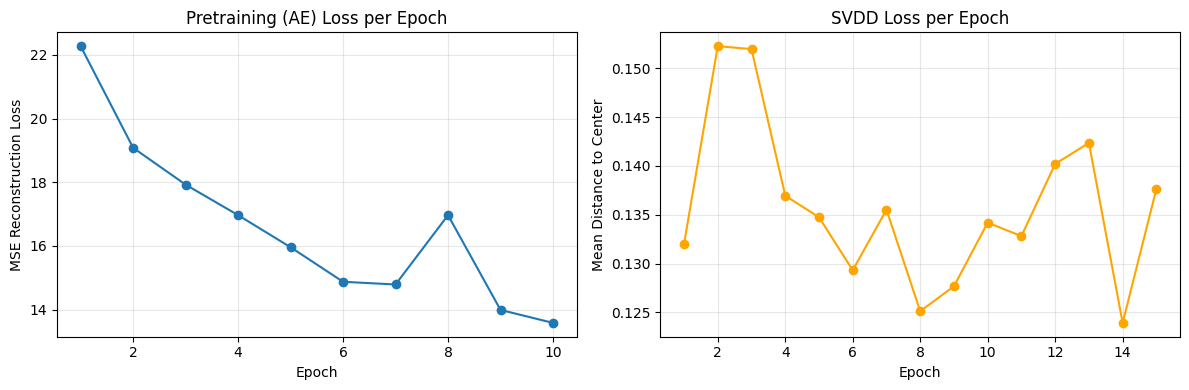

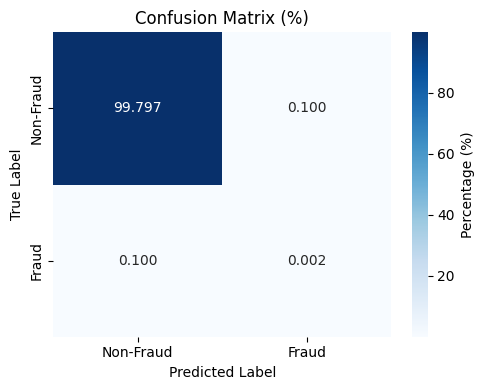

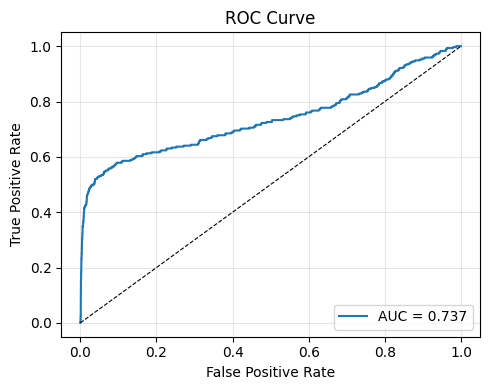

In [ ]:
# After you have run pretraining, built the network, trained SVDD, and computed scores/labels

# 2a) Loss curves 
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(svdd_model.train_losses_per_epoch)+1), svdd_model.train_losses_per_epoch, marker='o')
plt.title('Pretraining (AE) Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('MSE Reconstruction Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
if hasattr(svdd_model, 'svdd_losses_per_epoch') and svdd_model.svdd_losses_per_epoch:
    plt.plot(range(1, len(svdd_model.svdd_losses_per_epoch)+1), svdd_model.svdd_losses_per_epoch, marker='o', color='orange')
    plt.title('SVDD Loss per Epoch')
    plt.xlabel('Epoch'); plt.ylabel('Mean Distance to Center')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Run train_svdd first', ha='center', va='center')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2b) Confusion matrix as percentages (threshold by prevalence)
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

y_true = labels.astype(int)
# Threshold by class prevalence; fallback to 95th percentile if no positives
prevalence = y_true.mean() if y_true.size else 0
thr = np.quantile(scores, 1 - prevalence) if prevalence > 0 else np.quantile(scores, 0.95)
y_pred = (scores >= thr).astype(int)

cm = confusion_matrix(y_true, y_pred)
cm_pct = cm / cm.sum() * 100.0

plt.figure(figsize=(5,4))
sns.heatmap(cm_pct, annot=True, fmt=".3f", cmap='Blues',
            xticklabels=['Non-Fraud','Fraud'], yticklabels=['Non-Fraud','Fraud'],
            cbar_kws={'label':'Percentage (%)'})
plt.title('Confusion Matrix (%)')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 2c) ROC curve (use anomaly scores as y_score)
try:
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_val = roc_auc_score(y_true, scores)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_val:.3f}')
    plt.plot([0,1],[0,1],'k--', linewidth=0.8)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f'ROC not available: {e}')

In [ ]:
import qiskit_aer
print(qiskit_aer.AerSimulator().available_devices())

('CPU',)
